# July 27 - Aug 8 2023: Emoprox2 dataset: MAX ROIs: SINDy discovery

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
import pandas as pd
import pysindy as ps
import sklearn as skl
import sympy
from scipy.spatial.distance import pdist, cdist, squareform, cosine
from scipy import stats, integrate
import tvb
import networkx as nx
import copy
import matlab.engine
from itertools import product
from tqdm import tqdm

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# folders
sys.path.insert(0, proj_dir)

(CVXPY) Aug 08 04:54:00 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 08 04:54:00 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [3]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

## dataset

In [4]:
emoprox_dir = pjoin(os.environ['HOME'], 'emoprox_inventory_govinda/emoprox_extract_timeseries')

In [5]:
# ROI atlas/parcellation
atlas_df = pd.read_csv(f"{emoprox_dir}/masks/README_MAX_ROIs_final_gm_85.txt", delimiter='\t')
display(atlas_df)

roi = 'dorsal Insula'
roi_idx = np.where(atlas_df['Hemi'].str.contains('R') * atlas_df['ROI'].str.contains(roi))[0]
display(atlas_df.iloc[roi_idx])

,Hemi,ROI,Index,Voxels,File_Name
0,R,med. OFC,1,407,r-mOFC_2mm_MidlineCut_Amunts.nii.gz
1,L,med. OFC,2,339,l-mOFC_2mm_MidlineCut_Amunts.nii.gz
2,R,lat. OFC,3,56,r-lOFC_p.6_2mm_Amunts.nii.gz
3,L,lat. OFC,4,62,l-lOFC_p.6_2mm_Amunts.nii.gz
4,M,vmPFC1,5,67,vmPFC.nii.gz
...,...,...,...,...,...
80,L,PAG,81,24,lPAG_Ezra.nii.gz
81,R,CrusI-shackman,82,109,r-cerebellum-crusI_UTvUS_Shackman_sphere.nii.gz
82,L,CrusI-shackman,83,122,l-cerebellum-crusI_UTvUS_Shackman_sphere.nii.gz
83,R,CrusI-krienen,84,105,r-cerebellum-crusI_KrienenBuckner_sphere.nii.gz


,Hemi,ROI,Index,Voxels,File_Name
49,R,ant. dorsal Insula,50,235,Hammers-gm-0.5-2mm-AntDorsal-INS-r.nii.gz


In [6]:
# data
data_df = pd.read_pickle(f"{emoprox_dir}/dataframes/MAX_ROIs.pkl")

# for idx, row in data_df.iterrows():
    # row['proximity'] = row['proximity'] * row['censor'][:, 0]
    # row['proximity_hrf'] = row['proximity_hrf'] * row['censor'][:, 0]
    # data_df.iloc[idx] = row
data_df['proximity'] = data_df['proximity'].apply(lambda prox: sp.stats.zscore(prox))

df = data_df[data_df['pid'] == '001'][data_df['block'] == 1]
df = df.reset_index()

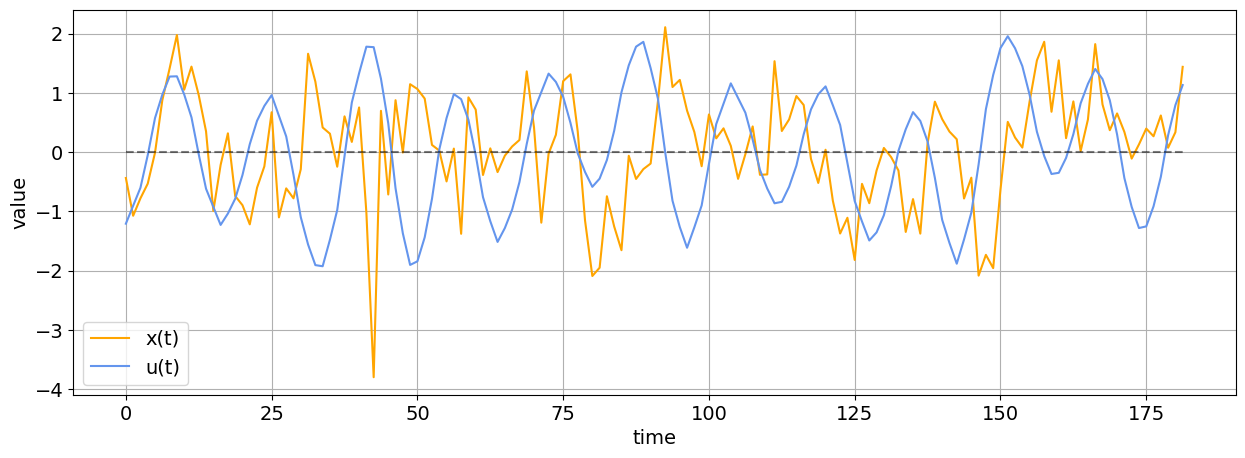

In [7]:
x = df.iloc[0]['timeseries'][:, roi_idx]
time = df.iloc[0]['time']
dt = time[1]-time[0]

# derivatives $\dot{x}$
# diff = ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)
diff = ps.SmoothedFiniteDifference()
xdiff = diff._differentiate(x, time)
x_ = np.concatenate([x[0], x[0] + np.cumsum(xdiff)[:-1]*dt])
prox = df.iloc[0]['proximity']

# basic plot check
plot_kws = dict(linewidth=4)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax = axs
ax.plot(time, x, c='orange', linestyle='-', label='x(t)')
ax.plot(time, prox, c='cornflowerblue', linestyle='-', label='u(t)')
# ax.plot(time, x_, c='green', linestyle='-', label='$\int{\dot{x}}$')
ax.plot(time, 0*time, c='black', linestyle='--', alpha=0.5)
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.legend()

## SINDy on fMRI signal

In [8]:
def discover_eqs(args, t_train, x_train, u_train, t_test, x_test, u_test, kwargs):
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=kwargs['threshold']),
        feature_library=ps.PolynomialLibrary(degree=kwargs['poly_order'], include_bias=args.include_bias),
        differentiation_method=ps.FiniteDifference(),
        feature_names=['x'] + [f'u{i}' for i in range(args.num_delays)],
        discrete_time=args.discrete_time,
    )
    model.fit(
        x=x_train, 
        t=t_train, 
        u=u_train, 
        multiple_trajectories=args.multiple_trajs,
        library_ensemble=args.lib_ensemble,
    )
    model.print()

    # simulate
    if ~args.discrete_time:
        x_sim = model.simulate(
            x0=x_test[0],
            t=t_test,
            u=u_test,
        )
    elif args.discrete_time:
        x_sim = model.simulate(
            x0=x_test[0],
            t=len(t_test),
            u=u_test,
        )

    # predicted vs empirical time series: 
    # 1.0 (perfect predictions) or 0.0 (imperfect predictions)
    r2 = skl.metrics.r2_score(x_test, x_sim)
    print(f"R2: {r2}")

    return x_sim

In [9]:
def get_u(args, u):
    u_ = np.zeros((u.shape[0], args.num_delays))
    for i in range(args.num_delays):
        u_[:, i] = np.roll(u, i)
    return u_

In [10]:
args.time = df.iloc[0]['time']
args.dt = args.time[1] - args.time[0]
args.num_delays = 3

args.multiple_trajs = True
args.lib_ensemble = True
args.include_bias = True
args.discrete_time = False

t_train = [None for _ in df.index]
x_train = copy.deepcopy(t_train)
u_train = copy.deepcopy(t_train)
for idx, row in df.iterrows():
    t_train[idx] = df.iloc[idx]['time']
    x_train[idx] = df.iloc[idx]['timeseries'][:, roi_idx]
    u_train[idx] = get_u(args, df.iloc[idx]['proximity'])

t_test = df.iloc[0]['time']
x_test = df.iloc[0]['timeseries'][:, roi_idx]
u_test = get_u(args, df.iloc[0]['proximity'])

kwargs = {'threshold':0.0, 'poly_order':3, 'n_freqs':1}
x_sim = discover_eqs(
    args, 
    t_train, x_train, u_train, 
    t_test, x_test, u_test, 
    kwargs,
)

(x)' = -0.089 1 + 0.027 x + 0.124 u0 + 0.237 u1 + -0.391 u2 + -0.003 x^2 + 0.157 x u0 + -0.245 x u1 + 0.120 x u2 + -0.642 u0^2 + 2.516 u0 u1 + -1.605 u0 u2 + -2.354 u1^2 + 2.996 u1 u2 + -0.855 u2^2 + -0.005 x^3 + 0.056 x^2 u0 + -0.098 x^2 u1 + 0.055 x^2 u2 + 0.492 x u0^2 + -1.681 x u0 u1 + 0.893 x u0 u2 + 1.392 x u1^2 + -1.421 x u1 u2 + 0.322 x u2^2 + -0.107 u0^3 + -0.512 u0^2 u1 + 1.702 u0^2 u2 + 1.646 u0 u1^2 + -5.658 u0 u1 u2 + 2.152 u0 u2^2 + -1.202 u1^3 + 4.854 u1^2 u2 + -3.806 u1 u2^2 + 0.980 u2^3


R2: -4.229239608863072


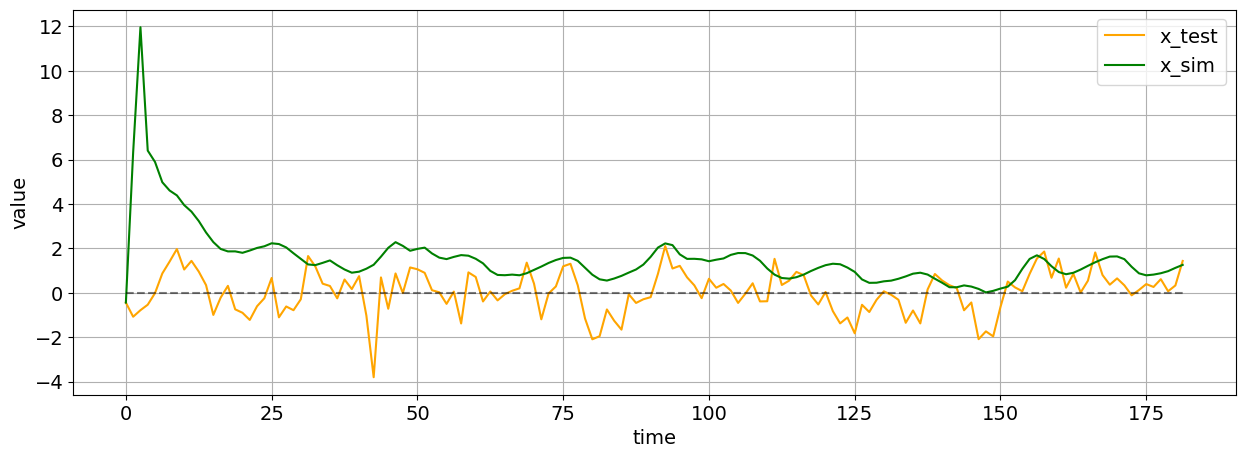

In [11]:
# plot check
plot_kws = dict(linewidth=4)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax = axs
ax.plot(t_test, x_test, c='orange', linestyle='-', label='x_test')
# ax.plot(t_test, u_test, c='purple', linestyle='-', label='prox.')
ax.plot(t_test, x_sim, c='green', linestyle='-', label='x_sim')
ax.plot(t_test, 0*t_test, c='black', linestyle='--', alpha=0.5)
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.legend()

## SINDy on proximity stimulus

In [12]:
df = data_df[data_df['pid'] == '001'][data_df['block'] == 1]
df = df.reset_index()
df

,index,pid,rid,block,timeseries,proximity,direction,speed,time,proximity_hrf,direction_hrf,speed_hrf,censor,block_mask
0,0,001,0,1,"[[0.8379856692518338, 1.5021724749622507, 0.88...","[-1.2078678270529946, -0.9044684197194248, -0....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0...","[0.00038334028973863177, 0.0015333611589545642...","[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[4.3784092777402576e-10, 0.3349688904772947, 0...","[1.4517088254665919e-09, 0.9995504155764687, 1...","[0.0, 0.0015323138494028148, 0.001533361158954...","[[True, True, True, True, True, True, True, Tr...","[True, True, True, True, True, True, True, Tru..."
1,2,001,1,1,"[[0.5763017654744047, 0.08734334097049039, 0.2...","[0.1370563750305292, -0.08112612414184353, -0....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0...","[0.00031826661311190607, 0.0012730664524474762...","[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[6.55548129538983e-10, 0.4235531810051557, 0.3...","[-1.4517088254665919e-09, -0.9995504155764687,...","[0.0, 0.0012721969282340848, 0.001273066452447...","[[True, True, True, True, True, True, True, Tr...","[True, True, True, True, True, True, True, Tru..."
2,4,001,2,1,"[[-0.3392797073968184, 1.426534152732058, 0.65...","[-0.03881290945394758, -0.2998282079005716, -0...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0,...","[0.00036505967169853104, 0.0014602386867941242...","[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[7.19244928993168e-10, 0.46332356704854677, 0....","[-1.4517088254665919e-09, -0.9995504155764687,...","[0.0, 0.0014592413210295708, 0.001460941689841...","[[True, True, True, True, True, True, True, Tr...","[True, True, True, True, True, True, True, Tru..."
3,6,001,3,1,"[[-0.4591977243631115, -0.07513433247036788, 0...","[-0.5121904912446311, -0.28057786888286124, -0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0...","[0.00034304386400987874, 0.001372175456039515,...","[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[5.042370806939312e-10, 0.3771633144236725, 0....","[1.4517088254665919e-09, 0.9995504155764687, 1...","[0.0, 0.001371238238833108, 0.0013721754560395...","[[True, True, True, True, True, True, True, Tr...","[True, True, True, True, True, True, True, Tru..."
4,8,001,4,1,"[[-1.0262497394891177, 0.06506924325393788, 0....","[0.2443542255730672, -0.017847413863765052, -0...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0,...","[0.00038495604701799246, 0.0015398241880718218...","[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[7.251748097672263e-10, 0.46566540835347, 0.40...","[-1.4517088254665919e-09, -0.9995504155764687,...","[0.0, 0.0015387724641705153, 0.001539836806854...","[[True, True, True, True, True, True, True, Tr...","[True, True, True, True, True, True, True, Tru..."


### single state variable

(u)[k+1] = 0.853 u[k] + 0.056 u[k]^3 + -0.012 u[k]^5


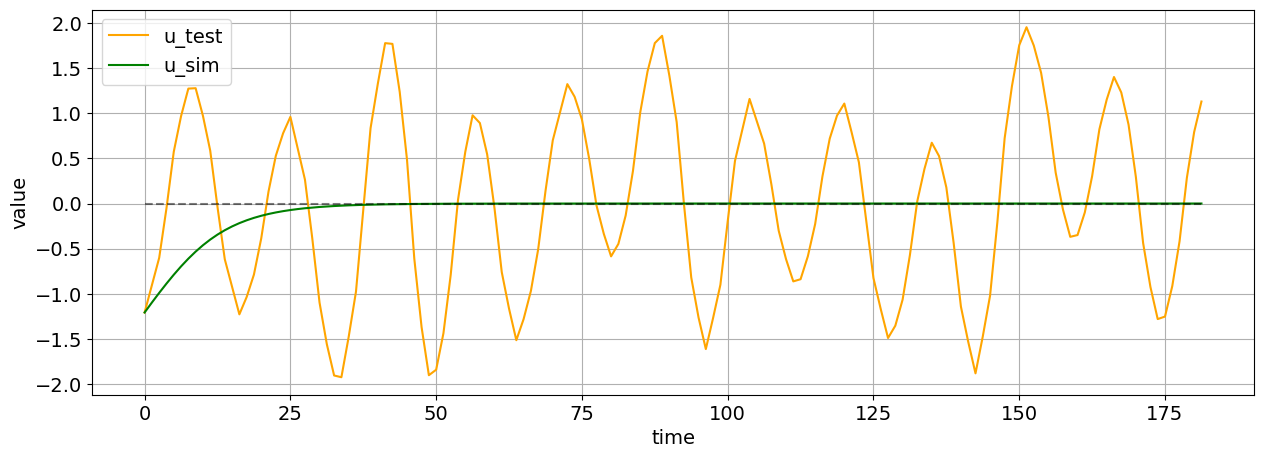

In [13]:
x_train = [row['proximity'] for _, row in df.iterrows()]
t_train = [row['time'] for _, row in df.iterrows()]

args.multiple_trajs = True
args.lib_ensemble = True
args.include_bias = True
kwargs = {'threshold':0.01, 'poly_order':30, 'n_freqs':10}
# build
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=kwargs['threshold']),
    feature_library=ps.PolynomialLibrary(degree=kwargs['poly_order'], include_bias=args.include_bias),
    # feature_library=ps.FourierLibrary(n_frequencies=kwargs['n_freqs']),
    differentiation_method=ps.FiniteDifference(),
    feature_names=['u'],
    discrete_time=True
)
# train
model.fit(
    x=x_train, 
    t=t_train,  
    multiple_trajectories=args.multiple_trajs,
    library_ensemble=args.lib_ensemble,
)
model.print()
# predict
x_test = x_train[0]
t_test = t_train[0]
x_sim = model.simulate(
    x0=x_test[0],
    t=len(t_test),
)
# plot check
plot_kws = dict(linewidth=4)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax = axs
ax.plot(t_test, x_test, c='orange', linestyle='-', label='u_test')
ax.plot(t_test, x_sim, c='green', linestyle='-', label='u_sim')
ax.plot(t_test, 0*t_test, c='black', linestyle='--', alpha=0.5)
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.legend()

### time-delay coordinates

(x0)' = -0.011 x0 + -0.393 x1
(x1)' = 0.404 x0


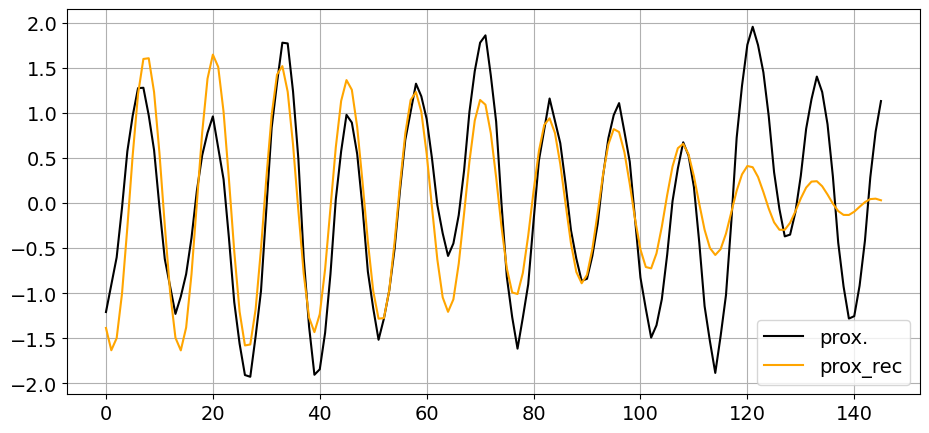

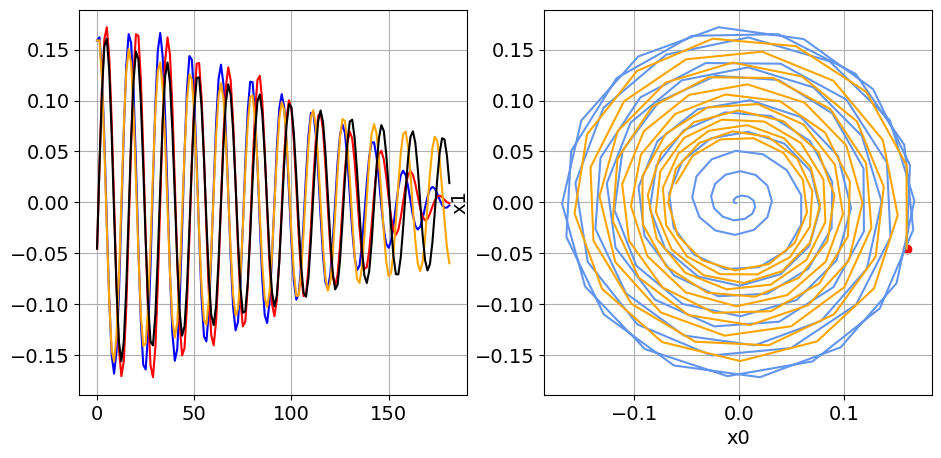

In [14]:
args.num_coords = 2 #np.argmin(np.diff(S))
x = []
for idx, row in df.iterrows():
    if idx != 0: continue
    n = row['proximity'].shape[0] // 1
    # Hankel matrix
    H = sp.linalg.hankel(row['proximity'])[np.ix_(np.arange(0, n), np.arange(0, n))]
    U, S, Vh = np.linalg.svd(H)
    S = np.diag(S)
    # eigen timeseries 
    x.append(
        Vh[:args.num_coords, :].T
    )

model = ps.SINDy(
    optimizer=ps.STLSQ(0.01),
    feature_library=ps.PolynomialLibrary(degree=10),
    differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=4),
    discrete_time=False
)
model.fit(
    x=x[0],
    t=1.25,
    multiple_trajectories=False,
    library_ensemble=False,
    ensemble=False
)
model.print()
x_test = x[0]
t_test = np.arange(0, 1.25*len(x_test), 1.25) # len(x_test)
x_sim = model.simulate(
    x0=x_test[0],
    t=t_test,
)
x_rec = (
    U[:, :args.num_coords] @
    S[np.ix_(np.arange(0, args.num_coords), np.arange(0, args.num_coords))] @
    x_sim.T
)[:, 0]

fig, axs = plt.subplots(1, 1, figsize=(11, 5))
ax = axs
ax.plot(df.iloc[0]['proximity'][:len(x_rec)], c='k', label='prox.')
ax.plot(x_rec, c='orange', label='prox_rec')
ax.legend()
ax.grid(True)

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
ax = axs[0]
ax.plot(t_test, x_test[:, 0], c='blue', label='$x_0$')
ax.plot(t_test, x_test[:, 1], c='red', label='$x_1$')
ax.plot(t_test, x_sim[:, 0], c='orange', label='x_sim$_0$')
ax.plot(t_test, x_sim[:, 1], c='black', label='x_sim$_1$')
# ax.legend()
ax.grid(True)

ax = axs[1]
ax.plot(x_test[:, 0], x_test[:, 1], c='cornflowerblue')
ax.plot(x_sim[:, 0], x_sim[:, 1], c='orange')
ax.scatter(x_sim[0,0], x_sim[0, 1], c='r')
ax.set(xlabel='x0', ylabel='x1')
ax.grid(True)

### 2D ODE

(x0)' = 1.000 x1
(x1)' = 0.002 1 + -0.124 x0 + -0.002 x1 + 0.002 x0^2 + 0.015 x0 x1 + -0.037 x1^2


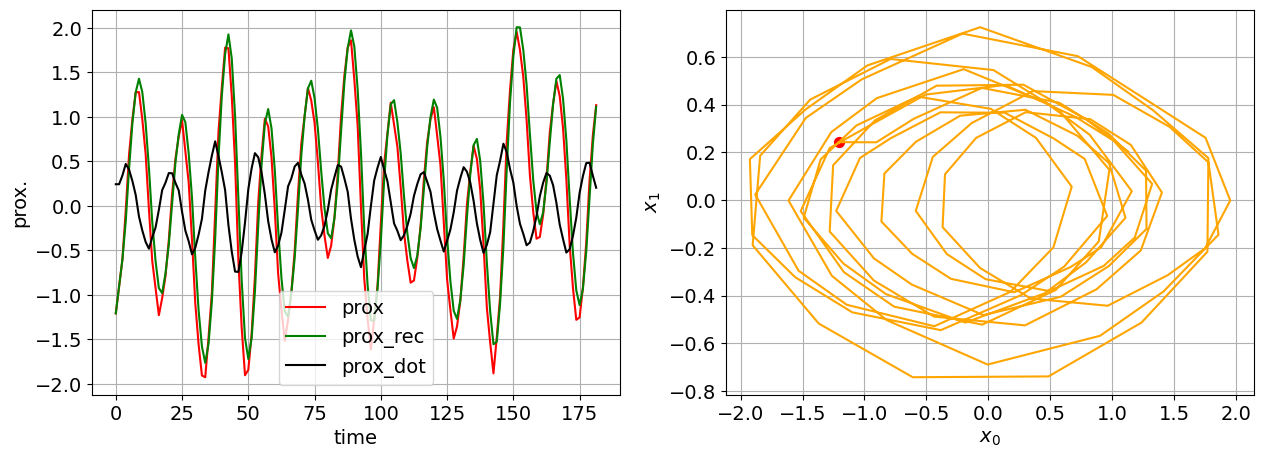

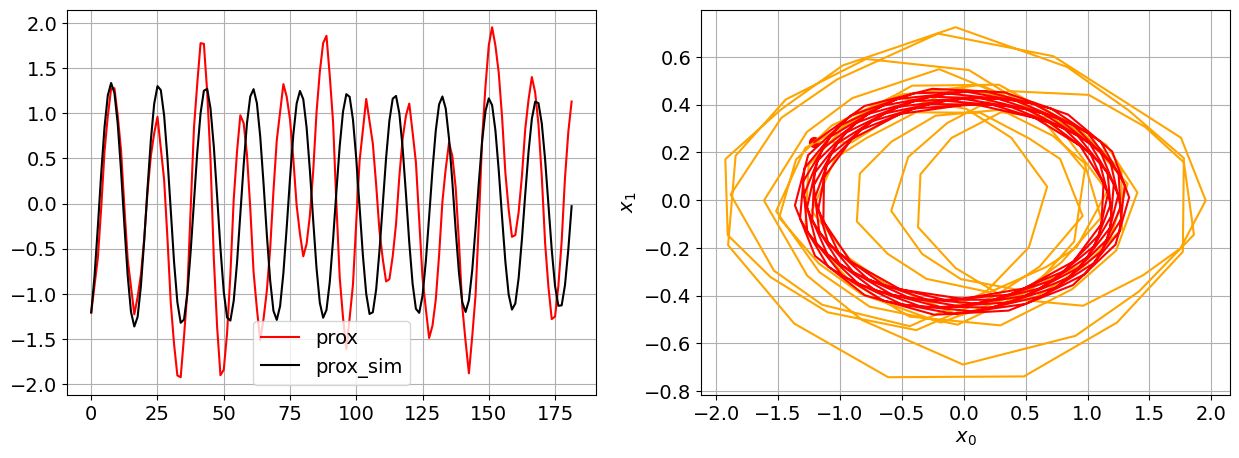

In [15]:
row = df.iloc[0]
t = row['time']
x0 = row['proximity']
differentiation_method = ps.FiniteDifference()
#ps.SmoothedFiniteDifference()
#ps.SINDyDerivative(kind='finite_difference', k=4)
x1 = differentiation_method._differentiate(x0, t)
dt = np.diff(t)[0]
x0_ = np.concatenate(([x0[0]], x0[0] + np.cumsum(x1)[:-1]*dt))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.plot(t, x0, 'r-', label='prox')
ax.plot(t, x0_, 'g-', label='prox_rec')
ax.plot(t, x1, 'k-', label='prox_dot')
ax.legend()
ax.grid(True)
ax.set(xlabel='time', ylabel='prox.')

ax = axs[1]
ax.plot(x0, x1, c='orange')
ax.set(xlabel='$x_0$', ylabel='$x_1$')
ax.scatter(x0[0], x1[0], s=50, c='r')
ax.grid(True)

x_train = np.stack([x0, x1], axis=-1)

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.002, normalize_columns=True),
    feature_library=ps.PolynomialLibrary(degree=2),
    differentiation_method=differentiation_method,
    feature_names=['x0', 'x1'],
)
model.fit(x=x_train, t=dt)
model.print()

x_sim = model.simulate(x_train[0], t)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ax = axs[0]
ax.plot(t, x_train[:, 0], 'r-', label='prox')
ax.plot(t, x_sim[:, 0], 'k-', label='prox_sim')
ax.legend()
ax.grid(True)

ax = axs[1]
ax.plot(x_train[:, 0], x_train[:, 1], c='orange', label='x_train')
ax.plot(x_sim[:, 0], x_sim[:, 1], c='red', label='x_sim')
ax.set(xlabel='$x_0$', ylabel='$x_1$')
ax.scatter(x0[0], x1[0], s=50, c='r')
ax.grid(True)

Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
1 = -0.031 x + 0.472 xx + 0.086 x_t + -0.163 x_tt + 0.006 xx_t + -0.008 xxx_t + -0.320 xx_tt + -0.151 xxx_tt
x = -0.025 1 + -0.094 xx + -0.004 x_t + -2.992 x_tt + 0.153 xx_t + 0.014 xxx_t + -0.942 xx_tt + -1.055 xxx_tt
xx = 0.409 1 + -0.127 x + -0.052 x_t + 0.008 x_tt + 0.155 xxx_t + -4.431 xx_tt + -0.478 xxx_tt
x_t = 0.013 1 + -0.005 xx + 0.010 xx_t + 0.689 xxx_t + -0.003 xx_tt
x_tt = -0.003 1 + -0.075 x + -0.001 xx + 0.006 xx_t + -0.001 xxx_t + 0.230 xxx_tt
xx_t = 0.031 x + -0.002 xx + 0.009 x_t + 0.059 x_tt + -0.088 xxx_t + 0.064 xxx_tt
xxx_t = -0.001 1 + 0.003 x + 0.020 xx + 0.614 x_t + -0.076 xx_t + 0.148 xx_tt + 0.018 xxx_tt
xx_tt = -0.008 1 + -0.034 x + -0.124 xx + 0.026 xxx_t + -0.151 xxx_tt
xxx_tt = -0.011 1 + -0.117 x + -0.039 xx + 1.024 x_tt + 0.027 xx_t + 0.014 xxx_t + -0.468 xx_tt


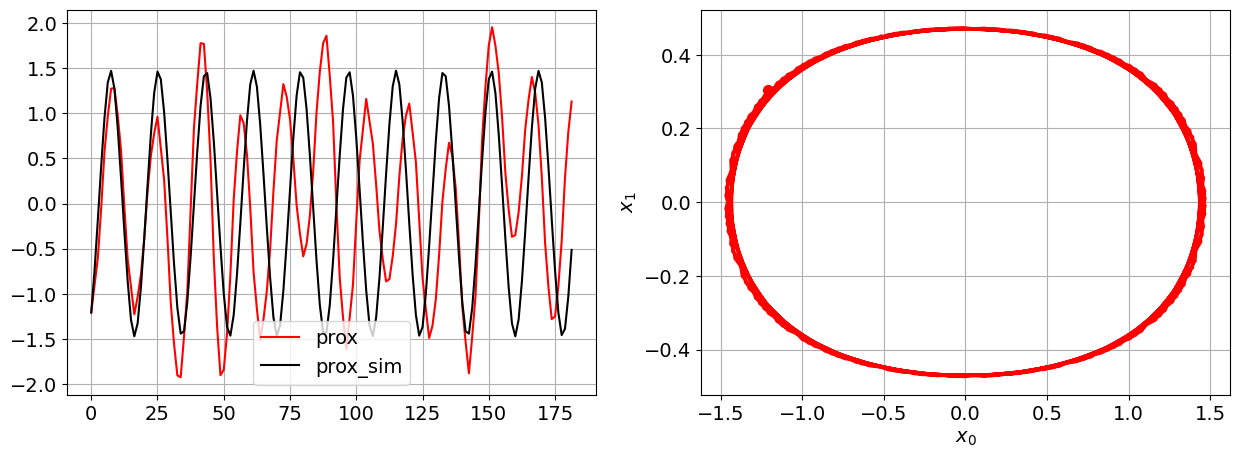

In [16]:
row = df.iloc[0]
t = row['time']
x = row['proximity']
x = np.reshape(x, (x.shape[0], 1))
x = [x]

# custom library
library_functions = [
    lambda x: x,
    lambda x: x*x,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x,
]
library = ps.PDELibrary(
    library_functions=library_functions,
    temporal_grid=t,
    function_names=library_function_names,
    include_bias=True,
    implicit_terms=True,
    derivative_order=2,
).fit(x)
library.transform(x)
# print(library.get_feature_names())

optimizer = ps.SINDyPI(
    threshold=0.1,
    tol=1e-5,
    thresholder="l1",
    max_iter=6000,
    # normalize_columns=True
)

model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library,
    feature_names=['x'],
)
model.fit(x, t, multiple_trajectories=True)
model.print()


def fun(t, x):
    return [x[1], (-0.075 * x[0]) / (1 - 0.23*x[0]**2)]
x0 = x


x_sim = sp.integrate.solve_ivp(
    fun, (t[0], t[-1]), [x[0][0,0], np.diff(x[0], axis=0)[0, 0]], t_eval=t, **integrator_keywords
).y.T

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ax = axs[0]
ax.plot(t, x[0][:, 0], 'r-', label='prox')
ax.plot(t, x_sim[:, 0], 'k-', label='prox_sim')
ax.legend()
ax.grid(True)

ax = axs[1]
# ax.plot(x[0][:, 0], x[0][:, 1], c='orange', label='x_train')
ax.plot(x_sim[:, 0], x_sim[:, 1], c='red', label='prox_sim')
ax.set(xlabel='$x_0$', ylabel='$x_1$')
ax.scatter(x_sim[0, 0], x_sim[0, 1], s=50, c='r')
ax.grid(True)

### power spectral density of stimulus

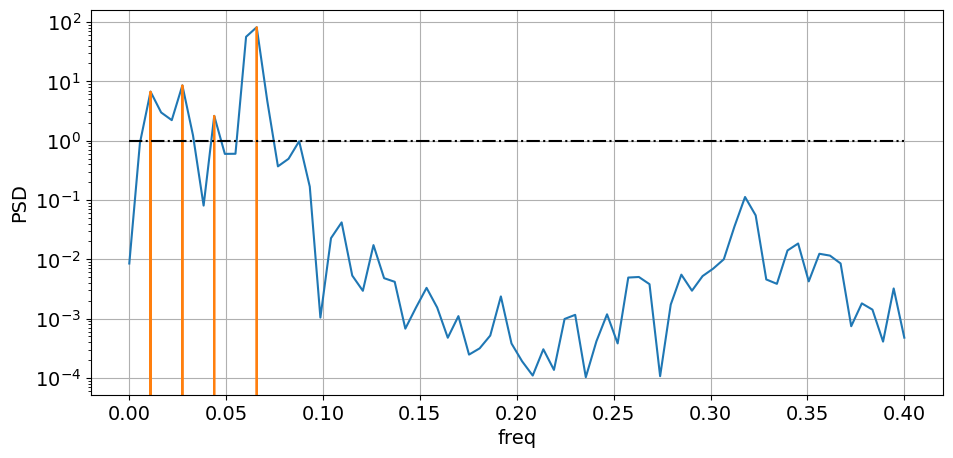

In [17]:
row = df.iloc[0]
t = row['time']
dt = np.diff(t)[0]
x = row['proximity']
f, S = sp.signal.welch(x, fs=1/dt, nperseg=1*1024)
p, _ = sp.signal.find_peaks(S)
peaks = np.zeros_like(S)
peaks[p[[0, 1, 2, 3]]] = S[p[[0, 1, 2, 3]]]

fig, axs = plt.subplots(1, 1, figsize=(11, 5))
ax = axs
ax.semilogy(f, S)
ax.semilogy(f, peaks)
ax.semilogy(f, 10**0*np.ones_like(f), 'k-.')
ax.set(xlabel='freq', ylabel='PSD')
ax.grid(True)


(x)' = -0.152 sin(1 x) + 0.034 cos(1 x) + 0.237 sin(2 x) + -0.041 cos(2 x) + -0.233 sin(3 x) + 0.067 cos(3 x) + 0.157 sin(4 x) + -0.069 cos(4 x) + -0.066 sin(5 x) + 0.054 cos(5 x)


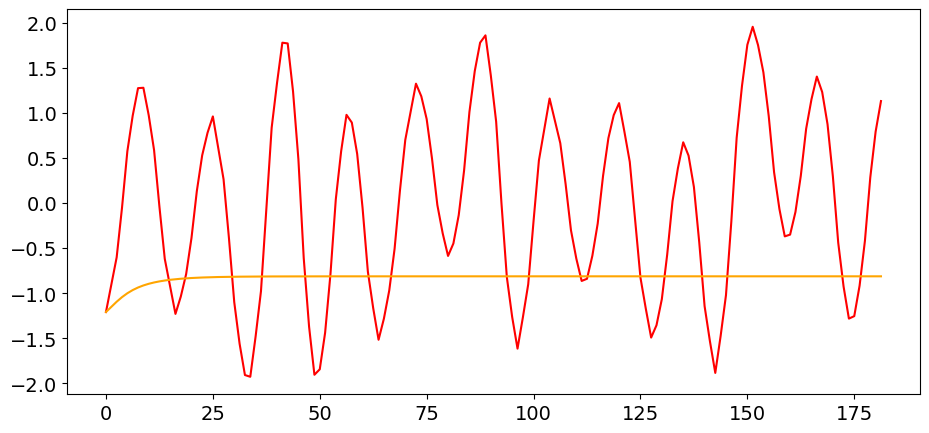

In [18]:
# x_rec = np.sum([np.sqrt(s)*np.sin(2*np.pi*f[i]*t) for i, s in enumerate(peaks) if s != 0], axis=0)
x_train = x.reshape((x.shape[0], 1))
model = ps.SINDy(
    optimizer=ps.STLSQ(0.001),
    feature_library=ps.FourierLibrary(5),
    feature_names=['x'],
)
model.fit(x_train, t=dt, )
model.print()
x_sim = model.simulate(
    x_train[0], t=t
)

fig, axs = plt.subplots(1, 1, figsize=(11, 5))
ax = axs
ax.plot(t, x, 'r')
ax.plot(t, x_sim, 'orange')

## upsampling signals

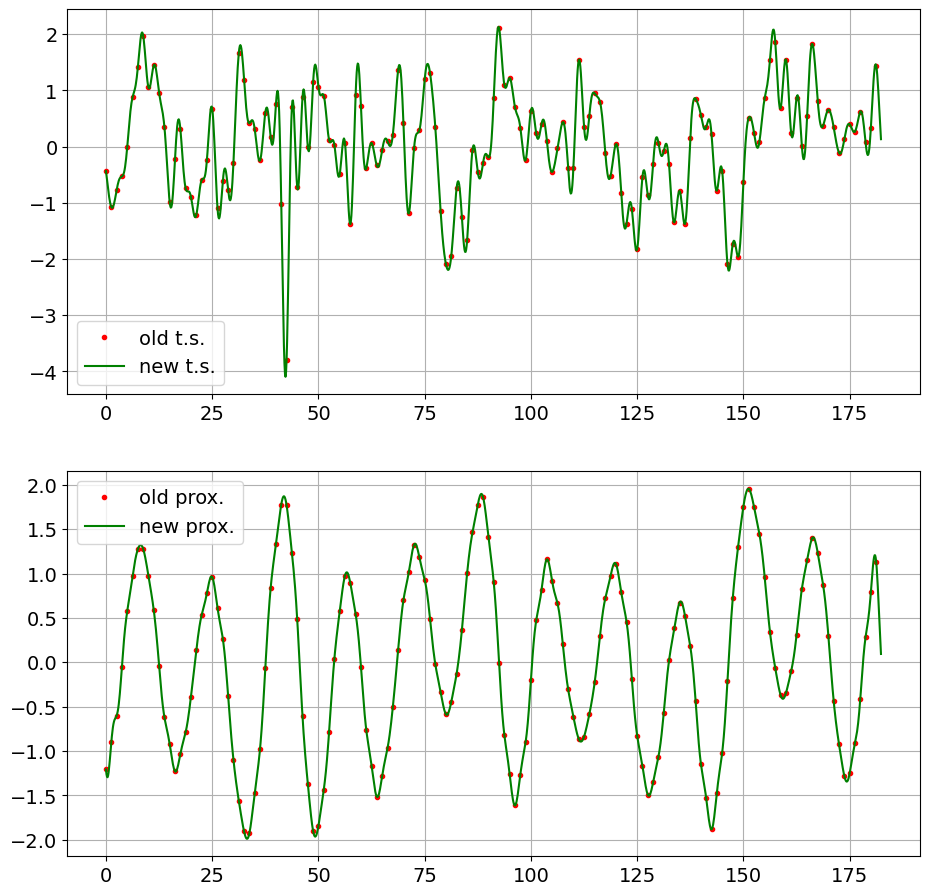

In [19]:
args.factor = 10
df_resampled = pd.DataFrame(columns=df.columns)
for idx, row in df.iterrows():
    num_samples = row['time'].shape[0]
    row['proximity']= sp.signal.resample_poly(
        x=row['proximity'],
        # num=args.factor*num_samples,
        up=args.factor,
        down=1,
        # t=row['time'],
    )
    row['timeseries'] = sp.signal.resample_poly(
        x=row['timeseries'],
        # num=args.factor*num_samples,
        up=args.factor,
        down=1,
        # t=row['time'],
        axis=0,
    )
    dt = np.diff(row['time'])[0] / args.factor
    row['time'] = np.arange(0, row['proximity'].shape[0])*dt
    df_resampled.loc[idx] = row
df_resampled = df_resampled.reset_index()

fig, axs = plt.subplots(2, 1, figsize=(11, 11))
# plot time series
ax = axs[0]
x = df.iloc[0]['timeseries'][:, roi_idx]
t = df.iloc[0]['time']
xr = df_resampled.iloc[0]['timeseries'][:, roi_idx]
tr = df_resampled.iloc[0]['time']
ax.plot(t, x, 'r.', label='old t.s.')
ax.plot(tr, xr, 'g-', label='new t.s.')
ax.grid(True)
ax.legend()

# plot proximity
ax = axs[1]
x = df.iloc[0]['proximity']
t = df.iloc[0]['time']
xr = df_resampled.iloc[0]['proximity']
tr = df_resampled.iloc[0]['time']
ax.plot(t, x, 'r.', label='old prox.')
ax.plot(tr, xr, 'g-', label='new prox.')
ax.grid(True)
ax.legend()

### on proximity

#### time-delay coordinates

In [20]:
def discover_eqs_timedelay(args, df):
    args.num_coords = 2 #np.argmin(np.diff(S))
    t, x = [], []
    U_, S_, Vh_ = [], [], []
    for idx, row in df.iterrows():
        # if idx != 0 : continue
        n = row['proximity'].shape[0] // 2
        # Hankel matrix
        H = sp.linalg.hankel(row['proximity'])[np.ix_(np.arange(0, n), np.arange(0, n))]
        U, S, Vh = np.linalg.svd(H)
        S = np.diag(S)
        # eigen timeseries 
        if args.use_Vh:
            x.append(
                Vh[:args.num_coords, :].T
            )
        elif args.use_U:
            x.append(
                U[:, :args.num_coords]
            )
        U_.append(U)
        S_.append(S)
        Vh_.append(Vh)
    
    dt = np.diff(row['time'][:2])[0]
    model = ps.SINDy(
        optimizer=ps.STLSQ(0.0),
        feature_library=ps.PolynomialLibrary(degree=2),
        differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=4),
        discrete_time=False
    )
    model.fit(
        x=x[0],
        t=dt,
        multiple_trajectories=False,
        library_ensemble=False,
        ensemble=False
    )
    model.print()
    x_test = x[0]
    t = np.arange(0, dt*len(x_test), dt) #len(x_test),
    x_sim = model.simulate(
        x0=x_test[0],
        t=t, 
    )

    if args.use_Vh:
        x_recovered = (
            U_[0][:, :args.num_coords] @ 
            S_[0][np.ix_(np.arange(0, args.num_coords), np.arange(0, args.num_coords))] @ 
            x_sim.T
        )[:, 0]
    elif args.use_U:
        x_recovered = (
            x_sim @ 
            S_[0][np.ix_(np.arange(0, args.num_coords), np.arange(0, args.num_coords))] @ 
            Vh_[0][:args.num_coords, :]
        )[:, 0]

    return t, x_test, x_sim, x_recovered

args.use_Vh = False
args.use_U = True
t, x_test, x_sim, x_rec = discover_eqs_timedelay(args, df=df_resampled)

(x0)' = -0.011 x0 + 0.395 x1 + 0.138 x0^2 + 0.033 x0 x1 + 0.125 x1^2
(x1)' = -0.401 x0 + 0.009 x1 + 0.127 x0^2 + -0.010 x0 x1 + 0.155 x1^2


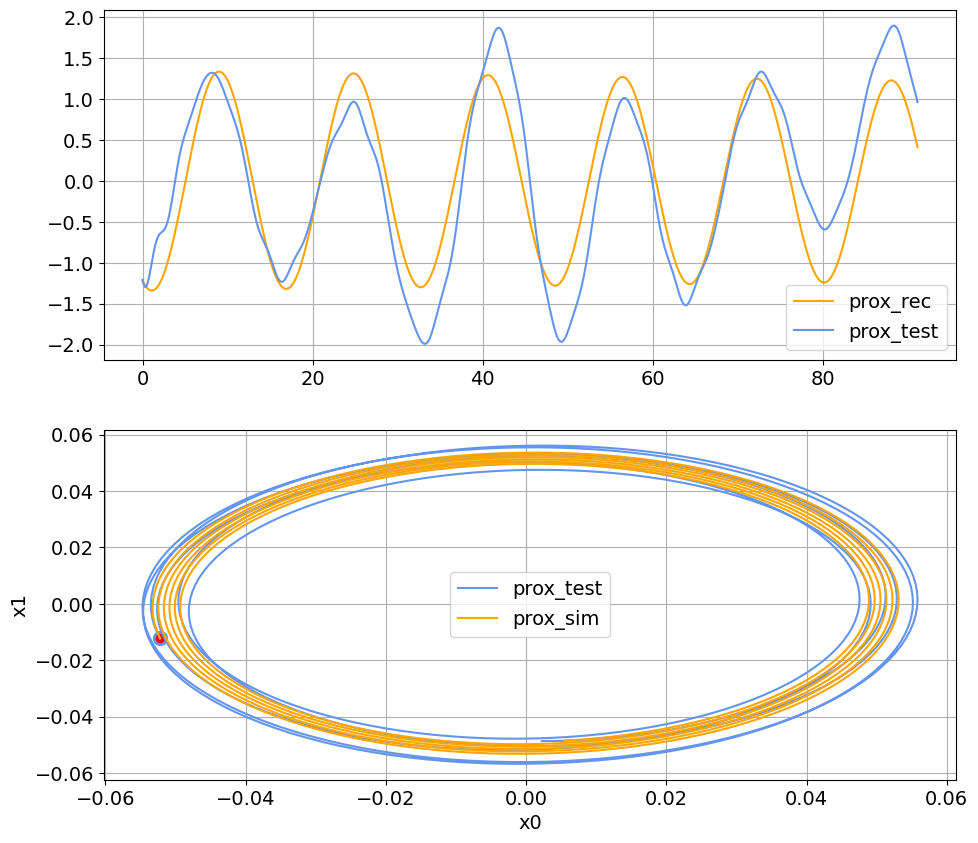

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(11, 10))

ax = axs[0]
ax.plot(t, x_rec, c='orange', label='prox_rec')
ax.plot(t, df_resampled.iloc[0]['proximity'][:t.shape[0]], c='cornflowerblue', label='prox_test')
ax.grid(True)
ax.legend()

ax = axs[1]
ax.plot(x_test[:, 0], x_test[:, 1], c='cornflowerblue', label='prox_test')
ax.scatter(x_test[0, 0], x_test[0, 1], c='cornflowerblue', s=100)
ax.plot(x_sim[:, 0], x_sim[:, 1], c='orange', label='prox_sim')
ax.scatter(x_sim[0,0], x_sim[0, 1], c='r')
ax.set(xlabel='x0', ylabel='x1')
ax.grid(True)
ax.legend()

#### 2nd order ODE

(x0)' = 1.000 x1
(x1)' = -0.157 x0 + 0.045 x0 x1 + -0.015 x1^2


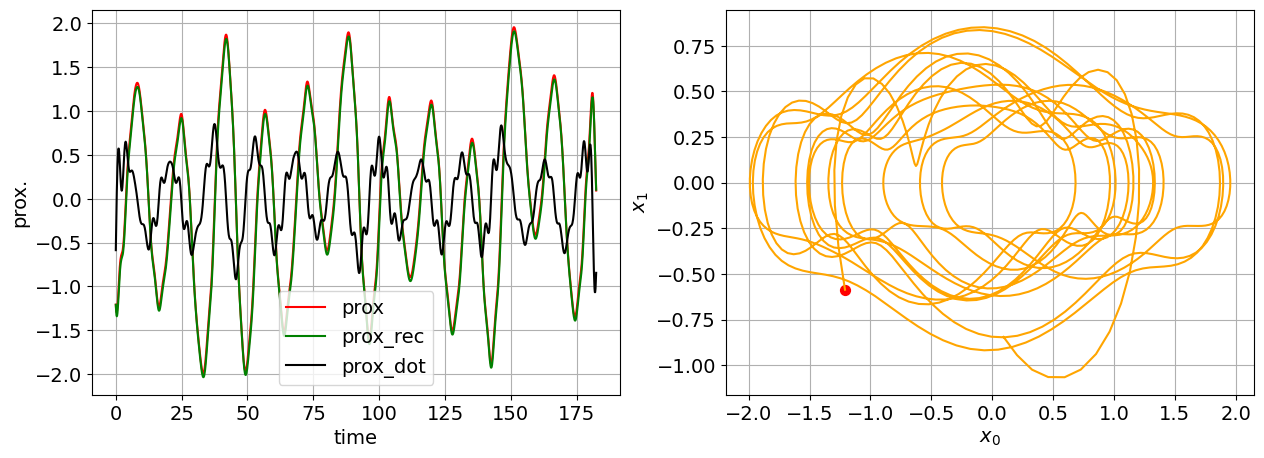

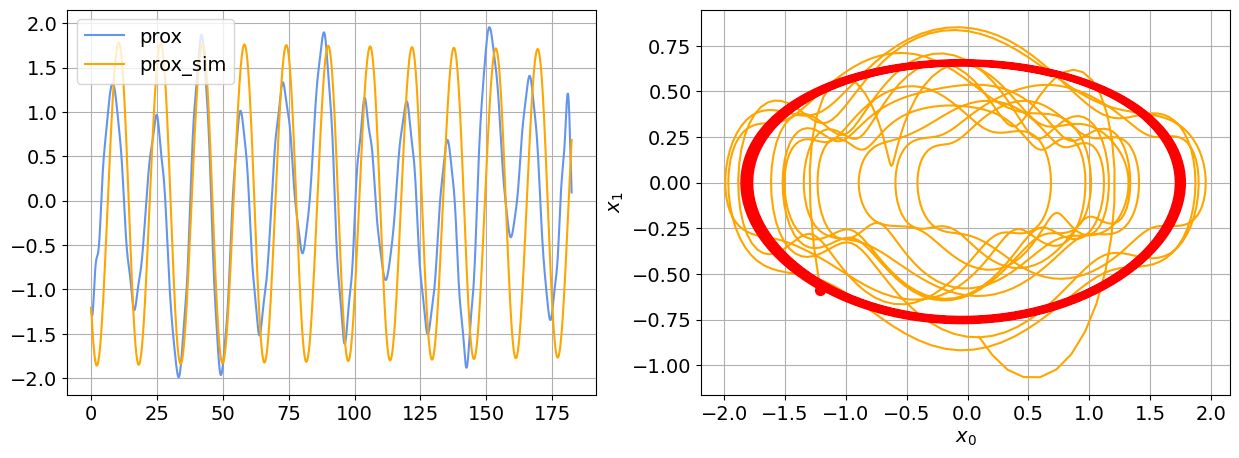

In [22]:
row = df_resampled.iloc[0]
t = row['time']
x0 = row['proximity']
x1 = ps.SmoothedFiniteDifference()._differentiate(x0, t) #ps.SINDyDerivative(kind='finite_difference', k=4)._differentiate(x0, t)
dt = np.diff(t)[0]
x0_ = np.concatenate(([x0[0]], x0[0] + np.cumsum(x1)[:-1]*dt))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.plot(t, x0, 'r-', label='prox')
ax.plot(t, x0_, 'g-', label='prox_rec')
ax.plot(t, x1, 'k-', label='prox_dot')
ax.legend()
ax.grid(True)
ax.set(xlabel='time', ylabel='prox.')

ax = axs[1]
ax.plot(x0, x1, c='orange')
ax.set(xlabel='$x_0$', ylabel='$x_1$')
ax.scatter(x0[0], x1[0], s=50, c='r')
ax.grid(True)
x_train = np.stack([x0, x1], axis=-1)

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.01),
    feature_library=ps.PolynomialLibrary(degree=2),
    differentiation_method=ps.SmoothedFiniteDifference(),
    feature_names=['x0', 'x1'],
)
model.fit(x=x_train, t=dt)
model.print()

x_sim = model.simulate(x_train[0], t)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ax = axs[0]
ax.plot(t, x_train[:, 0], 'cornflowerblue', label='prox')
ax.plot(t, x_sim[:, 0], 'orange', label='prox_sim')
ax.legend()
ax.grid(True)

ax = axs[1]
ax.plot(x_train[:, 0], x_train[:, 1], c='orange', label='x_train')
ax.plot(x_sim[:, 0], x_sim[:, 1], c='red', label='x_sim')
ax.set(xlabel='$x_0$', ylabel='$x_1$')
ax.scatter(x0[0], x1[0], s=50, c='r')
ax.grid(True)

### on fMRI signal

#### time-delay coordinates

In [23]:
def discover_eqs_timedelay(args, df):
    args.num_coords = 2 #np.argmin(np.diff(S))
    t, x = [], []
    U_, S_, Vh_ = [], [], []
    for idx, row in df.iterrows():
        # if idx != 0 : continue
        n = row['timeseries'].shape[0] // 2
        # Hankel matrix
        H = sp.linalg.hankel(row['timeseries'][:, roi_idx])[np.ix_(np.arange(0, n), np.arange(0, n))]
        U, S, Vh = np.linalg.svd(H)
        S = np.diag(S)
        # eigen timeseries 
        x.append(
            Vh[:args.num_coords, :].T
        )
        U_.append(U)
        S_.append(S)
        Vh_.append(Vh)
    
    dt = np.diff(row['time'][:2])[0]
    model = ps.SINDy(
        optimizer=ps.STLSQ(0.01),
        feature_library=ps.PolynomialLibrary(degree=2),
        differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=4),
        discrete_time=False
    )
    model.fit(
        x=x,
        t=dt,
        multiple_trajectories=True,
        library_ensemble=False,
        ensemble=False
    )
    model.print()
    x_test = x[0]
    t = np.arange(0, dt*len(x_test), dt) #len(x_test),
    x_sim = model.simulate(
        x0=x_test[0],
        t=t, 
    )

    x_recovered = (
        U_[0][:, :args.num_coords] @ 
        S_[0][np.ix_(np.arange(0, args.num_coords), np.arange(0, args.num_coords))] @ 
        x_sim.T
    )[:, 0]

    return t, x_test, x_sim, x_recovered

t, x_test, x_sim, x_rec = discover_eqs_timedelay(args, df=df_resampled)

(x0)' = -0.092 x1 + 0.143 x0^2
(x1)' = 0.096 x0 + 0.397 x0^2 + -0.226 x0 x1 + -0.247 x1^2


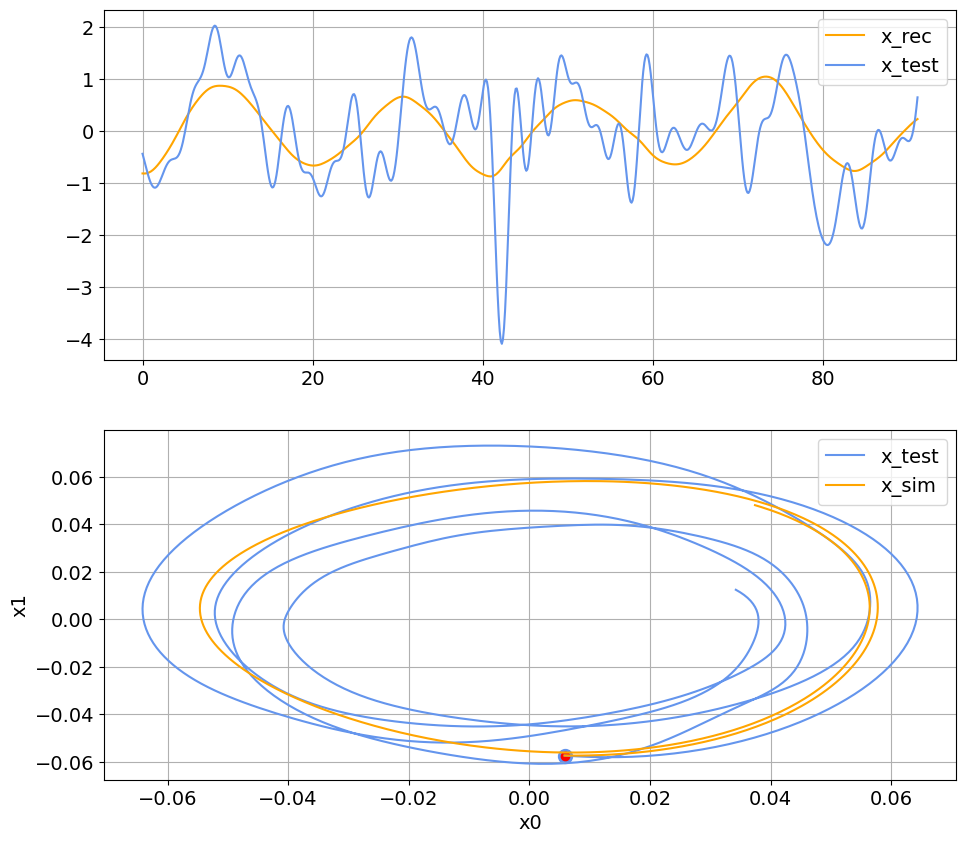

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(11, 10))

ax = axs[0]
ax.plot(t, x_rec, c='orange', label='x_rec')
ax.plot(t, df_resampled.iloc[0]['timeseries'][:t.shape[0], roi_idx], c='cornflowerblue', label='x_test')
ax.grid(True)
ax.legend()

ax = axs[1]
ax.plot(x_test[:, 0], x_test[:, 1], c='cornflowerblue', label='x_test')
ax.scatter(x_test[0, 0], x_test[0, 1], c='cornflowerblue', s=100)
ax.plot(x_sim[:, 0], x_sim[:, 1], c='orange', label='x_sim')
ax.scatter(x_sim[0,0], x_sim[0, 1], c='r')
ax.set(xlabel='x0', ylabel='x1')
ax.grid(True)
ax.legend()

## testing

### SINDy-PI, PDElibrary, WeakPDELibrary

With function names: 
['1', 'x0', 'x0x0', 'x0_t', 'x0_tt', 'x0x0_t', 'x0x0x0_t', 'x0x0_tt', 'x0x0x0_tt'] 

Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
1 = -0.14 x0 + 0.48 x0x0 + -0.20 x0_t + -0.65 x0_tt + -0.07 x0x0_t + 0.10 x0x0x0_t + 0.21 x0x0_tt + 0.12 x0x0x0_tt
x0 = -0.16 1 + 0.07 x0x0 + -0.55 x0_t + -2.09 x0_tt + 0.38 x0x0x0_t + 0.03 x0x0_tt + 0.25 x0x0x0_tt
x0x0 = 0.98 1 + 0.12 x0 + 0.22 x0_t + 0.76 x0_tt + 0.25 x0x0_t + -0.12 x0x0x0_t + -0.75 x0x0_tt + -0.15 x0x0x0_tt
x0_t = -0.21 1 + -0.53 x0 + 0.12 x0x0 + -2.13 x0_tt + -0.01 x0x0_t + 0.50 x0x0x0_t + 0.07 x0x0_tt + 0.37 x0x0x0_tt
x0_tt = -0.07 1 + -0.21 x0 + 0.04 x0x0 + -0.22 x0_t + 0.12 x0x0x0_t + 0.03 x0x0_tt + 0.19 x0x0x0_tt
x0x0_t = -0.31 1 + -0.01 x0 + 0.56 x0x0 + -0.04 x0_t + -0.11 x0_tt + -0.01 x0x0x0_t + 0.57 x0x0_tt + 0.03 x0x0x0_tt
x0x0x0_t = 0.32 1 + 1.05 x0 + -0.18 x0x0 + 1.43 x0_t + 3.40 x0_tt + -0.01 x0x0_t + -0.11 x0x0_tt + -0.51 x0x0x0_tt
x0x0_tt = 0.58 1 + 0.08 x0 + -0.99 x0

['1',
 'x0',
 'x0x0',
 'x0_t',
 'x0_tt',
 'x0x0_t',
 'x0x0x0_t',
 'x0x0_tt',
 'x0x0x0_tt']

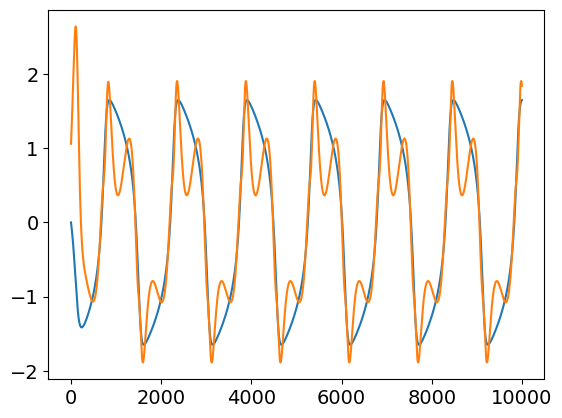

In [25]:
def Rayleigh_osc(t, x):
    return [x[1], (2 - (x[1]) ** 2) * x[1] - x[0]]

# Generate measurement data
dt = 0.005
t_train = np.arange(0, 50, dt)
t_train_span = (t_train[0], t_train[-1])

x0_train = [1, 0]
x_train = sp.integrate.solve_ivp(Rayleigh_osc, t_train_span, x0_train,
                    t_eval=t_train, **integrator_keywords).y.T

# Only train on the data for x, chop the other variable!
x_train = x_train[:, 0].reshape(len(t_train), 1)

# Define custom functions up to quadratic terms
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Define PDELibrary which generates up to first order temporal derivatives
sindy_library = ps.PDELibrary(
    library_functions=library_functions,
    temporal_grid=t_train,
    function_names=library_function_names,
    include_bias=True,
    implicit_terms=True,
    derivative_order=2
)

lib = sindy_library.fit(x_train)
lib.transform(x_train)
print("With function names: ")
print(lib.get_feature_names(), "\n")

sindy_opt = ps.SINDyPI(
    threshold=1e-4,
    tol=1e-5,
    thresholder="l1",
    max_iter=6000,
    # normalize_columns=True
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t_train)
model.print(precision=2)

x_dot_true = model.differentiate(x_train, t=t_train)
x_dot_pred = model.predict(x_train)  # default returns d/dt of all 15 features!

plt.figure()
plt.plot(x_dot_true)
plt.plot(x_dot_pred[:, 3])

sindy_library.get_feature_names()